# Usage: Training a Simple Classifier on the FashionMNIST Dataset

- Example consists of training a simple pytorch model using `FitLoop`.
- Demonstrates the more than the basic usage of `FitLoop`.

*Imports are called when required.*

## Data

### Obtaining
Getting the data and converting it into dataloaders

In [1]:
import numpy as np
from torchvision.transforms import ToTensor
from torchvision.datasets import FashionMNIST

In [2]:
"""
The returned values are torch `Dataset`s.
"""
train_ds_all = FashionMNIST("data",train=True, transform=ToTensor(), download=True)
test_ds = FashionMNIST("data",train=False, transform=ToTensor(), download=True)

labels = np.unique(train_ds_all.targets)
class_names = ["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]
class_num = len(class_names)

- Creating `Subset`s from `train_ds_all`
- Using 3000 samples for validation, 0.05 of training data

In [3]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

In [4]:
"""
Generating shuffled and stratified indices for 
splitting `train_ds_all` into a train and test dataset.
"""
idx = np.arange(len(train_ds_all))
targets = train_ds_all.targets   
train_idx, valid_idx = train_test_split(idx, train_size=0.95, stratify=targets)

"""
Subsets of train_ds_all form the generated indices.
"""
train_ds = Subset(train_ds_all, train_idx)
valid_ds = Subset(train_ds_all, valid_idx)

print(f"len :: train_ds:{len(train_ds)} valid_ds:{len(valid_ds)} test_ds:{len(test_ds)}")
print(f"data shape :: {train_ds[0][0].shape}")

len :: train_ds:57000 valid_ds:3000 test_ds:10000
data shape :: torch.Size([1, 28, 28])


Creating `DataLoader`s for trianing, validation and testing `Dataset`s

In [5]:
from torch.utils.data import DataLoader

In [6]:
batch_size = 16

train_dl = DataLoader(train_ds, batch_size=batch_size)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)
test_dl = DataLoader(test_ds, batch_size=batch_size)

print(f"batches :: train_dl:{len(train_dl)} valid_dl:{len(valid_dl)} test_dl:{len(test_dl)}")

batches :: train_dl:3563 valid_dl:188 test_dl:625


### Visualizing

In [7]:
import matplotlib.pyplot as plt

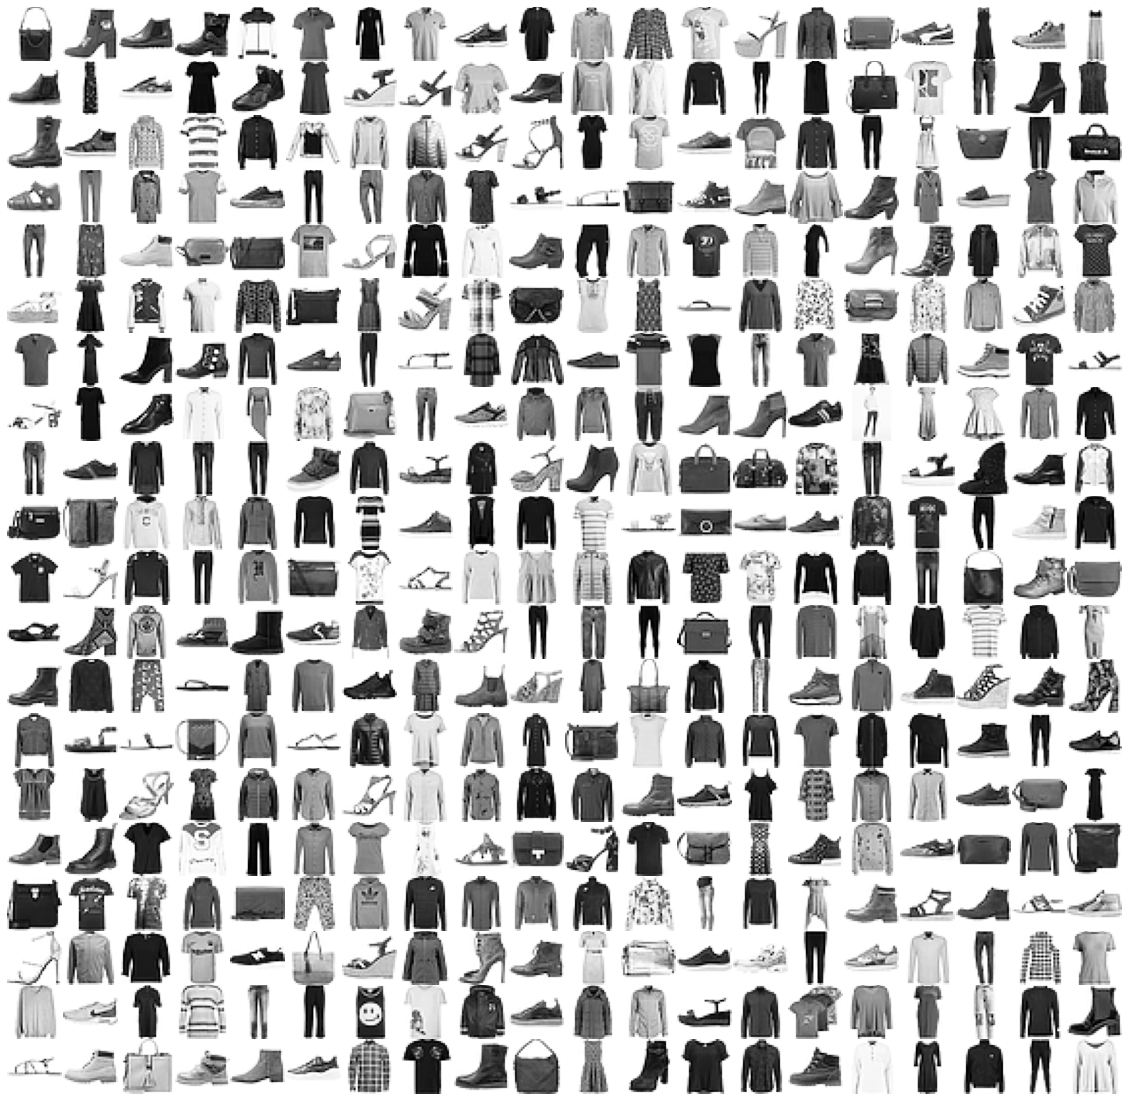

In [8]:
r = 20
c = 20

# Transform to convert to displayable format.
tr = lambda x: x.numpy().reshape(28,28)

# Indices to select random samples from train_ds
idx = np.random.permutation(np.arange(len(train_ds)))[:r*c]

# Plot the images
plt.figure(figsize=(20,20))
plt.subplots_adjust(wspace=0, hspace=0)
for i in range(r*c):
    img = tr(train_ds[i][0])
    plt.subplot(r,c,i+1,)
    plt.imshow(img, cmap="Greys")
    plt.axis('off')

---

## CNN Initialization

Creating a simple CNN using `Sequential`

In [9]:
import torch.nn as nn

Model definition

In [10]:
out_features = len(labels)
model = nn.Sequential(
    nn.Conv2d(1,16,3),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    nn.Conv2d(16,32,3),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    nn.Flatten(),
    nn.Dropout(0.4),
    nn.Linear(800,256),
    nn.ReLU(),
    nn.Linear(256,out_features)
)

## Training

In [11]:
from fitloop import FitLoop

### Initialization

#### Loop Stage Functions
There are 3 stages in a loop:
1. **Batch Step**
    - This is the stage where forward pass occurs `model(X)`.
    - If the loop is in `train` phase then `loss.backward` and `optimizer.step` have to be called.
    - This stage should return batch wise metrics that have to be tracked.
2. **Epoch End**
    - This is the stage that is run at the end of an epoch ie after the model 
      has looped over all the data in the batch.
    - This stage should return epoch level metrics that have to be tracked.
3. **Epoch Start**
    - This is the stage at the start of the epoch before the batch level metrics are reset.
    - This stage function is optional.
   
For each phase ie "train" or "valid" or "test" the above stage functions can be defined.

**Input**: A `LoopState` object from which the model, optimizer, loss_function, calculated metrics and all values passed to the `FitLoop` constructor can be accessed.  

**Output**: A dict consisting of that metrics that need to be tracked, one of the metric names should match the `criteria` arg in the `FitLoop.fit` function for it restore the best model.

*The stage functions defined below are same as the ones used by default.*

##### Batch Step Stage Functions

In [12]:
"""
Defining the batch step stage functions
- train_step
- valid_step
- test_step

floop: FitLoop
"""
# common_step is defined because some of the computations
# are shared between the three batch step functions.
def common_step(floop):
    """
    The batch is automatically cast to the device and dtype
    passed in the constructor.
    """
    X, y = floop.batch
    y_ = floop.model(X)
    loss = floop.loss_function(y_,y)
    
    """
    Values in `rdict` will be tracked.
    
    floop.batch_size: number of samples in the batch.
    """
    rdict = {
        "running_loss":loss.item() * floop.batch_size,
        "running_correct":(y_.argmax(dim=1)==y).sum().float().item()
    }
    return loss, rdict

def train_step(floop):
    loss, rdict = common_step(floop)
    loss.backward()
    
    """
    floop.optimizer.zero_grad() is called before the 
    batch step.
    
    This can be manually set if the `define_all` arg 
    if `FitLoop.fit` is set to True.
    """
    floop.optimizer.step()
    return rdict

def valid_step(floop):
    _, rdict = common_step(floop)
    return rdict

def test_step(floop):
    _, rdict = common_step(floop)
    return rdict

##### Epoch End Stage Functions

In [13]:
"""
For this example the calculations in the end step
are the same for all the three phases so only one function
is required.
"""
def common_epoch_end(floop):
    """
    The `running_loss` and `running_correct`
    values are returned as torch Tensors if possible.
    
    floop.size: The number of samples in the dataset.
    """
    return {
        "loss": floop['running_loss'].sum().float().item() / floop.size,
        "accuracy":floop['running_correct'].sum().float().item() / floop.size
    }

#### configure_optimizer
```python
configure_optimizer(floop:FitLoop) -> None
```
- This function is required so that when the model is reset
  to it's last best state during training the optimizer parameter groups can be reset.
- If this function isn't set, `FitLoop.optimizer` parameter groups will have to be set
  manually, else the weights won't update on further training.
- Model weights are reset:
    - After training if `load_best` arg is `True` in the `FitLoop.fit` function.
    - When `FitLoop.reset` is called.
    - When `FitLoop.run_sanity_check` or `FitLoop.run_profiler` are called.

- `configure_optimizer` can be called using `FitLoop.configure_optimizer`.

In [14]:
def configure_optimizer(floop, lr=None):
    params = model.parameters()
    param_group_dict = {'params':params}
    
    if lr is not None:
        param_group_dict['lr'] = lr
    
    floop.optimizer.param_groups.clear()
    floop.optimizer.add_param_group(param_group_dict)

Initializing the optimizer.

In [15]:
from torch.optim import Adam

In [16]:
params = model.parameters()
optimizer = Adam(params, lr=5e-3)
loss_function = nn.CrossEntropyLoss()

Initializing to get a `FitLoop` trainer

In [17]:
from fitloop import FitLoop

`fdict` is the dict of kwargs passed to the model.

```python
    fdict = {
        "model":model
    }
    FitLoop(**fdict)
```

is the same as

```python
    FitLoop(model=model)
```

In [18]:
params = model.parameters()

fdict = {
    "model":model,
    "loss_function":loss_function,
    "optimizer":optimizer,
    
    # DataLoaders
    "train_dl":train_dl,
    "valid_dl":valid_dl,
    "test_dl":test_dl,
    
    # Batch Step Stage Functions
    "train_step":train_step,
    "valid_step":valid_step,
    "test_step":test_step,
    
    # Epoch End Stage Functions
    "train_epoch_end": common_epoch_end,
    "valid_epoch_end": common_epoch_end,
    "test_epoch_end": common_epoch_end,
    
    # Function to 
    "configure_optimizer":configure_optimizer,
    
    # Model Evaluation
    "criteria": "accuracy", # Returned in valid_epoch_end stage function dict
    
    # Model Preservation
    "save_to_disk": True # Will save pretrained and best model to disk
}

trainer = FitLoop(**fdict)

### Pretrain Checks

#### Sanity Check
- Will run the loop for both training and testing.
- While testing the validation data is used if `use_test_dl` is not `True`
- `steps`: number of batches to iterate over.

In [19]:
trainer.run_sanity_check(epochs=2, steps=5)

RUNNING SANITY CHECK: TRAIN LOOP - 2 EPOCH(s), 5 STEP(s)


[1/2] - train :: loss: 0.0033 | accuracy: 0.0002 
        valid :: loss: 0.0589 | accuracy: 0.0083 
        epoch time: 00 s 167 ms


[2/2] - train :: loss: 0.0029 | accuracy: 0.0005 
        valid :: loss: 0.0516 | accuracy: 0.0073 
        epoch time: 00 s 177 ms

-----
total time: 00 s 400 ms
best score: -inf

RUNNING SANITY CHECK: TEST LOOP - 5 STEP(s)


test :: loss: 0.0612 | accuracy: 0.0037 

-----
total time: 00 s 073 ms


#### Profiler
- Used to check how much time is being take by each stage  of the loop.
- Values with a '_t' at the end pretain to the test loop.

In [20]:
profiler_times = trainer.run_profiler()

RUNNING PROFILER: TRAIN LOOP 1 EPOCH(s)
  train dl :: batches: 3563 batch_size:   16 last_batch:    8 dataset_size:  57000
  valid dl :: batches:  188 batch_size:   16 last_batch:    8 dataset_size:   3000




RUNNING PROFILER: TEST LOOP 
  test  dl :: batches:  625 batch_size:   16 last_batch:   16 dataset_size:  10000




AVERAGE TIMES
1. initialize:       00 s 003 ms 961 us
2. train
  1. epoch_start:    00 s 721 ms 999 us
  2. step:           00 s 007 ms 619 us
  3. batch_inner:    00 s 007 ms 773 us
  4. batch_loop:     33 s 904 ms 907 us
  5. epoch_end:      00 s 000 ms 551 us
  6. phase_inner:    33 s 905 ms 601 us
3. valid
  1. epoch_start:    00 s 041 ms 999 us
  2. step:           00 s 001 ms 902 us
  3. batch_inner:    00 s 001 ms 969 us
  4. batch_loop:     00 s 631 ms 193 us
  5. epoch_end:      00 s 156 ms 799 us
  6. phase_inner:    00 s 631 ms 362 us
4. phase loop:       34 s 581 ms 840 us
5. epoch
  1. inner:          34 s 583 ms 446 us
  2. loop:           34 s 624 ms 019 us
  3. inner_t:        02 s 319 ms 136 us
  4. loop_t:         02 s 320 ms 092 us
6. restore model:    00 s 008 ms 656 us
7. total:            34 s 636 ms 680 us
8. initialize_t:     00 s 002 ms 955 us
9. test
  1. epoch_start_t:  00 s 555 ms 000 us
  2. step_t:         00 s 002 ms 198 us
  3. batch_inner_t:  00 s 002 

### Fit
- Running the fit loop.
- `print_every`: prints the stats after given intervals and also after the first epoch.
- `continue_loop`: asks whether to continue training.

In [21]:
trainer.fit(epochs=4, continue_loop=2)

[1/4] - train :: loss: 0.5280 | accuracy: 0.8032 
        valid :: loss: 0.3796 | accuracy: 0.8583 
        epoch time: 37 s 757 ms


[2/4] - train :: loss: 0.4145 | accuracy: 0.8448 
        valid :: loss: 0.3763 | accuracy: 0.8510 
        epoch time: 36 s 983 ms
continue loop ([y]/n): y



[3/4] - train :: loss: 0.3964 | accuracy: 0.8509 
        valid :: loss: 0.3580 | accuracy: 0.8697 
        epoch time: 39 s 244 ms


[4/4] - train :: loss: 0.3857 | accuracy: 0.8551 
        valid :: loss: 0.3523 | accuracy: 0.8713 
        epoch time: 36 s 997 ms

-----
total time: 03 m 09 s 048 ms
best score: 0.8713


In [22]:
"""
Reconfigure the optimizer to use a lower learning rate and retrain
"""
trainer.configure_optimizer(trainer, lr=7e-4)
trainer.fit(epochs=10, print_every=3, continue_loop=5)

 [1/10] - train :: loss: 0.3179 | accuracy: 0.8812 
          valid :: loss: 0.2887 | accuracy: 0.8883 
          epoch time: 38 s 690 ms


 [3/10] - train :: loss: 0.2981 | accuracy: 0.8886 
          valid :: loss: 0.2759 | accuracy: 0.8913 
          epoch time: 37 s 410 ms


continue loop ([y]/n): y



 [6/10] - train :: loss: 0.2808 | accuracy: 0.8948 
          valid :: loss: 0.2709 | accuracy: 0.8910 
          epoch time: 36 s 641 ms


 [9/10] - train :: loss: 0.2695 | accuracy: 0.8974 
          valid :: loss: 0.2613 | accuracy: 0.8963 
          epoch time: 36 s 521 ms



-------
total time: 06 m 56 s 177 ms
best score: 0.9000


### Metrics

Metric names are the keys of dicts returend from 
the stage functions.

In [23]:
print("total number of epoch run: ", trainer.epoch_num)
print("number of train runs: ", trainer.M.train_runs)
print("best validation score: ", trainer.best_score)

total number of epoch run:  14
number of train runs:  2
best validation score:  0.9


#### Plotting

*kwargs are passed down to the underlying `plt.plot` function*

##### Basic:
```python
# Basic - Plots the value for the last run
trainer.plot('loss') 

# Basic - Plots the value for all the runs
trainer.plot('accuracy','all') 

# Basic - Plots the value for the 0th (first) run
trainer.plot('loss',0) 
```

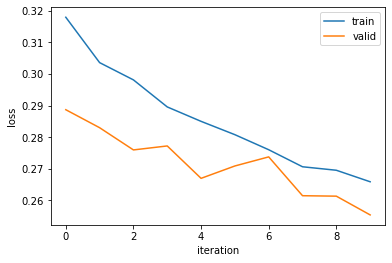

In [24]:
trainer.plot('loss')

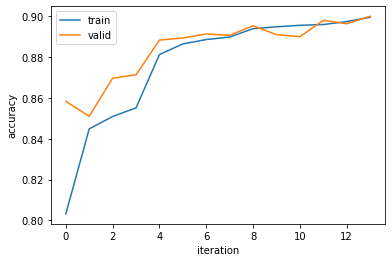

In [25]:
trainer.plot('accuracy','all')

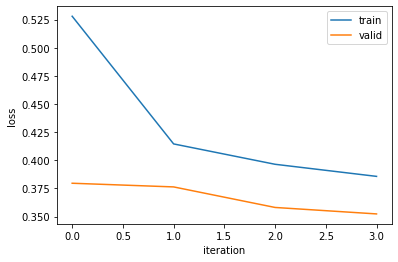

In [26]:
trainer.plot('loss',0)

##### Plotting by selected phase and stage
Form: `FitLoop.M.[phase].plot(metric_name, run_number, stage)`
```python
# Defaults in order of precedence [epoch_end,batch_step,epoch_start]
trainer.M.valid.plot('accuracy','all')

# Plots the running_loss for the first run for valid_step stage function
trainer.M.valid.plot('running_loss',0, 'batch_step')

# Plots the accuracy for the second run for the train_epoch_end stage function
trainer.M.valid.plot('accuracy',1 ,'epoch_end')
```

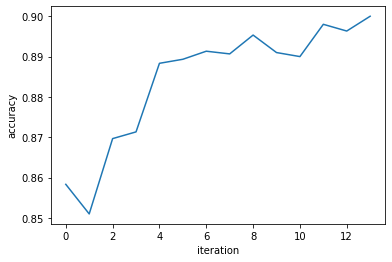

In [27]:
trainer.M.valid.plot('accuracy','all')

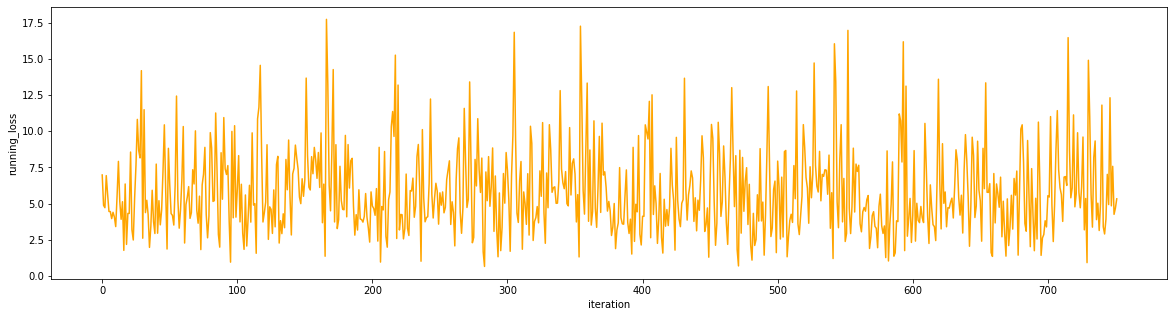

In [28]:
plt.figure(figsize=(20,5))
trainer.M.valid.plot('running_loss',0,'batch_step',color='orange') # kwargs are passed on

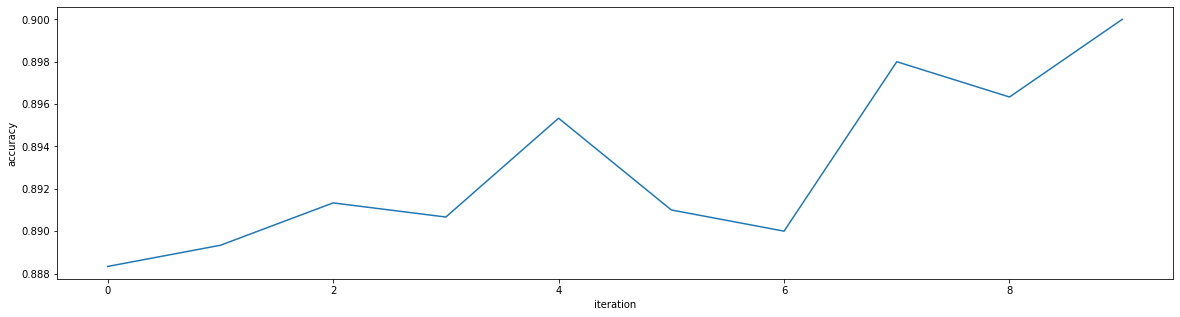

In [29]:
plt.figure(figsize=(20,5))
trainer.M.valid.plot('accuracy',1,'epoch_end')

#### Accessing Values
Form: `FitLoop.M.[phase].[stage][metric_name][run_number]`

```python
# Returns all metrics in the train phase for the batch step stage
trainer.M.train.batch_step

# Returns the second run accuracy for the valid phase from the epoch_end stage
trainer.M.valid.epoch_end['accuracy'][1]
```

In [30]:
trainer.M.train.batch_step

{'running_loss': [array([36.59490585, 36.5254364 , 39.870121  , ...,  7.27967644,
          6.03913689,  4.56966877]),
  array([5.1887989 , 4.54825592, 8.21441078, ..., 5.54320383, 1.16386342,
         1.76315475])],
 'running_correct': [array([ 2.,  2.,  0., ..., 12., 13.,  6.]),
  array([15., 15., 12., ..., 14., 16.,  7.])]}

In [31]:
trainer.M.valid.epoch_end['accuracy'][1]

array([0.88833333, 0.88933333, 0.89133333, 0.89066667, 0.89533333,
       0.891     , 0.89      , 0.898     , 0.89633333, 0.9       ])

### Testing
Checking accuracy and loss using the passed test data.

In [32]:
trainer.test()

test :: loss: 0.2762 | accuracy: 0.9001 

-----
total time: 02 s 330 ms


### Model/FitLoop State

If `save_to_dict` kwarg is set then `FitLoop` object will save a pretrained model and the model that has the 
highest score ase described by the `criteria` kwarg.

In [33]:
"""
Default values to deal with model state.
"""
print("default save path:", trainer.save_path)
print("default pretrained model name:" ,trainer.pretrained_model_name)
print("default best model name:" ,trainer.best_model_name,"\n")
print("save path contents:\n",*list(trainer.save_path.iterdir()))

default save path: models
default pretrained model name: pretrained_5752.pt
default best model name: best_bb0f.pt 

save path contents:
 models/pretrained_5752.pt models/best_bb0f.pt models/pretrained_a220.pt


**Reset**: Trainer can be reset to initial pretrained state, this resets the Metrics also.

In [34]:
trainer.reset()
trainer.test()

test :: loss: 2.3012 | accuracy: 0.1203 

-----
total time: 02 s 326 ms


In [35]:
"""
Model weights can be deleted using
"""
trainer.del_best_model()
trainer.del_pretrained_model()